In [1]:
import cv2
from cv2 import threshold
import numpy as np
import sys
import os
import json
from torchvision import models
from tqdm import tqdm
from pytorch3d.renderer import look_at_view_transform
from math import ceil
import torch
from pytorch3d.io import load_obj, load_ply
from scipy.spatial.transform import Rotation as scipy_rot
from matplotlib import pyplot as plt
from probabilistic_formulation.tests.test_factors_lines import create_k3d_plot
import copy
import ipyplot

%load_ext autoreload
%autoreload 2

from leveraging_geometry_for_shape_estimation.keypoint_matching.get_matches_3d import load_information_depth_camera,create_pixel_bearing,pb_and_depth_to_wc
from leveraging_geometry_for_shape_estimation.probabilistic_pose_and_shape.pose import init_Rs,init_Ts,get_pb_real_grid,get_R_limits,get_T_limits, create_pose_info_dict, check_gt_pose_in_limits, get_nearest_pose_to_gt
from leveraging_geometry_for_shape_estimation.probabilistic_pose_and_shape.ground_plane import get_model_to_infos,sample_Ts_ground_plane,filter_Ts
from leveraging_geometry_for_shape_estimation.probabilistic_pose_and_shape.translation_from_lines_v9 import *
from leveraging_geometry_for_shape_estimation.probabilistic_pose_and_shape.visualise_T_factors import plot_lines_T_correct_visualisation, get_pointsize_from_Ts
from leveraging_geometry_for_shape_estimation.probabilistic_pose_and_shape.translation_from_lines_visualise_v2 import visualise_single_example
from leveraging_geometry_for_shape_estimation.segmentation.meshrcnn_vis_tools import draw_boxes
from leveraging_geometry_for_shape_estimation.utilities.write_on_images import draw_lines
from leveraging_geometry_for_shape_estimation.data_conversion.create_dirs import dict_replace_value

from probabilistic_formulation.utilities import create_all_possible_combinations,get_uvuv_p_from_superpoint,create_all_possible_combinations_uvuv_p_together
from probabilistic_formulation.factors.factors_T.factors_lines_multiple_T import get_factor_reproject_lines_multiple_T, get_factor_reproject_lines_multiple_T_threshold, get_factor_reproject_lines_multiple_T_with_Scale
from probabilistic_formulation.factors.factors_T.bbox import get_factor_bbox_multiple_T
from probabilistic_formulation.tests.test_reproject_lines import load_lines_2D,load_lines_3D,get_cuboid_line_dirs_3D,plot_lines_T,plot_bbox, plot_points_T

In [2]:
exp_path = '/scratch/fml35/experiments/eval_classifier_grid/exp_001'

global_info = exp_path + '/global_information.json'
with open(global_info,'r') as f:
    global_config = json.load(f)

global_config["general"]["gpu"] = 0

In [3]:

global_config = dict_replace_value(global_config,'/scratch/fml35/','/scratches/octopus/fml35/')
global_config = dict_replace_value(global_config,'/scratch2/fml35/','/scratches/octopus_2/fml35/')

global_config["hierachial_grid_search"]["stages"][0]["info_T"]["steps_per_dim"] = 4


target_folder = global_config["general"]["target_folder"]
model_to_infos = get_model_to_infos('scannet')


cfg_1 = copy.deepcopy(global_config)
cfg_2 = copy.deepcopy(global_config)

In [4]:
configs = [cfg_1]
# line_indices_2ds = [None,[1,4,24]]
line_indices_2ds = [None,None]
line_indices_3ds = [None,None]
use_gt_retrievals = [True,False]
use_gt_Rs = [False,False]

specific_Ts = [None]



names = ['scene0011_00-000300_00_000_01.json']

In [5]:
classifier_config = load_json(global_config["pose_and_shape_probabilistic"]["reproject_lines"]["classifier_exp_path"] + '/config.json')
classifier_config = process_config(classifier_config)
classifier_config = dict_replace_value(classifier_config,'/scratch2/fml35/','/scratches/octopus_2/fml35/')

classifier_config['data']['dims_per_pixel'] = 7
classifier_config['model']['n_outputs'] = 1
classifier_config['data']["use_preloaded_depth_and_normals"] = False
classifier_config['data']["dir_path_2d_train"] = "/scratch/fml35/datasets/own_datasets/leveraging_geometry_for_shape_estimation/scannet/data_03/train"
classifier_config['data']["dir_path_2d_val"] = "/scratch/fml35/datasets/own_datasets/leveraging_geometry_for_shape_estimation/scannet/data_03/val"

if global_config["general"]["run_on_octopus"] == 'False':
        classifier_config = dict_replace_value(classifier_config,'/scratch/fml35/','/scratches/octopus/fml35/')
        classifier_config = dict_replace_value(classifier_config,'/scratch2/fml35/','/scratches/octopus_2/fml35/')
network = load_classifier(cfg_1,classifier_config)
scale_range = load_json(determine_base_dir(global_config,'segmentation') + '/scaling_limits.json')

segmentation_dir = determine_base_dir(global_config,'segmentation') + '/segmentation_infos'
bbox_roca_with_object_infos_dir = classifier_config['data']["dir_path_2d_val"] + '/bboxes_roca_with_object_infos'
infos_mapping_roca_id_to_gt = load_infos_maping_roca_id_gt(segmentation_dir,bbox_roca_with_object_infos_dir)


sampling for offset T
loading network
loaded network
cuda:0


KeyboardInterrupt: 

In [ ]:
dataset = Dataset_points(classifier_config,kind='val')

Loading 3d lines
Loading 2d lines
self.ratio_preloaded_original: 1


100%|██████████| 2/2 [00:00<00:00, 1376.31it/s]


In [ ]:
outputs=[]
img_names = ['selected_T_selected_S','closest_T_closest_S','closest_T_selected_S','selected_T_closest_S']
# pose_information,imgs,Ts,factors,area_accepted_all_Ts
for i in range(len(configs)):
        for j in range(configs[i]['hierachial_grid_search']['number_stages']):
            if j == 0:
                pose_information = None
            pose_information,_,factor_output = get_pose_single_example(configs[i],names[i],model_to_infos,pose_information,scale_range,j,dataset,infos_mapping_roca_id_to_gt,line_indices_2d=line_indices_2ds[i],line_indices_3d=line_indices_3ds[i],use_gt_retrieval=use_gt_retrievals[i],use_gt_R=use_gt_Rs[i],specific_Ts=specific_Ts[i],network=network,classifier_config=classifier_config)

            # eval_results = eval_factors(factor_output,np.array(pose_information["gt_T"]))
            # print(eval_results)
            imgs,img_annotations = visualise_single_example(global_config,names[i].replace('.json','_{}.json'.format(str(j).zfill(2))),factor_output,img_names,model_to_infos,classifier_config)
            eval_results = None
            output = (pose_information,factor_output,imgs,img_annotations,eval_results)
            outputs.append(output)



FileNotFoundError: [Errno 2] No such file or directory: '/scratches/octopus_2/fml35/datasets/own_data/data_leveraging_geometry_for_shape/data_01/nn_infos/scene0011_00-000300_01.json'

: 


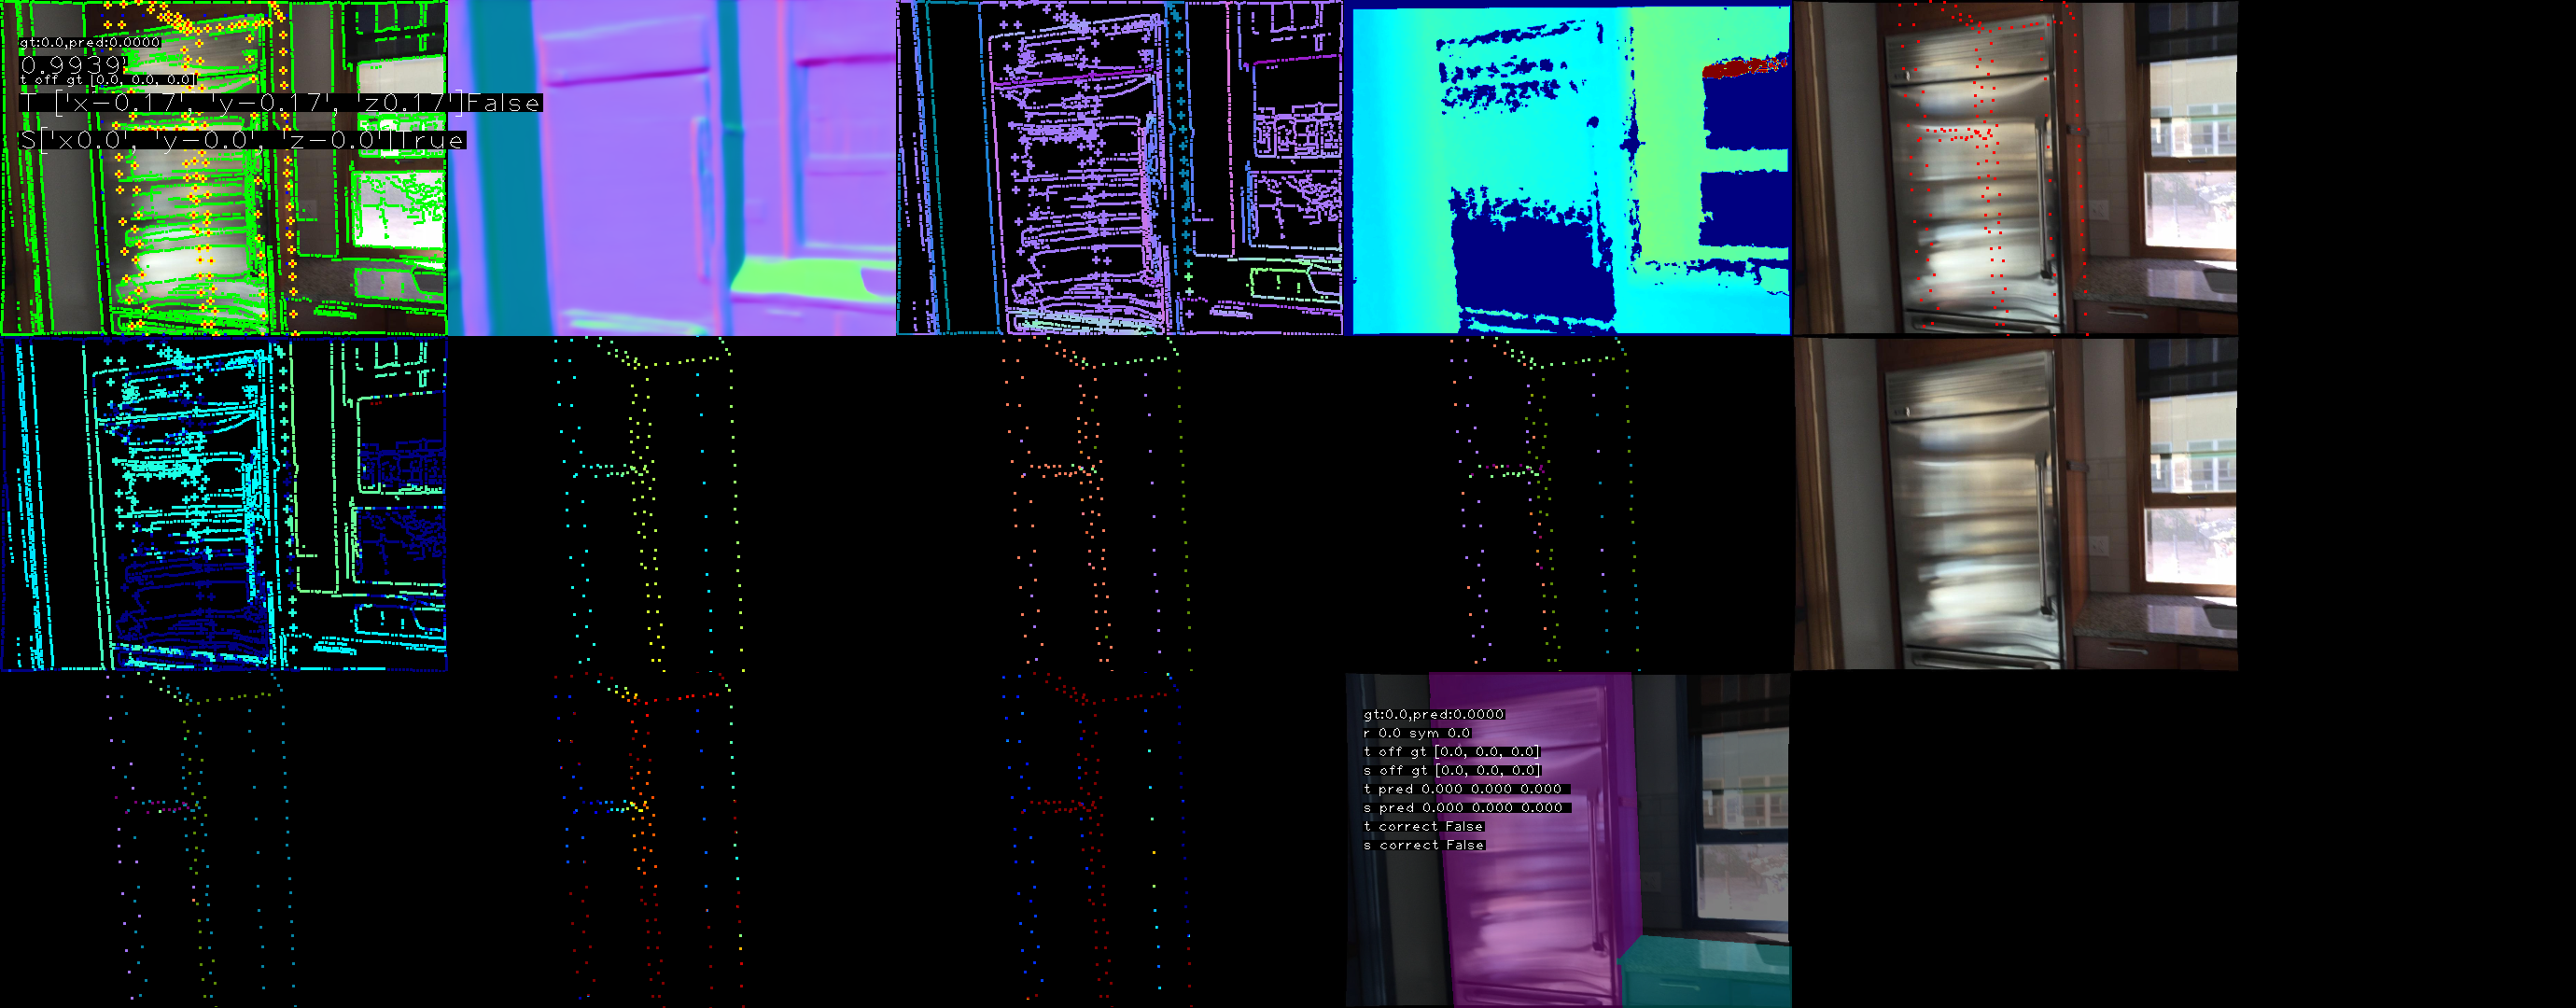


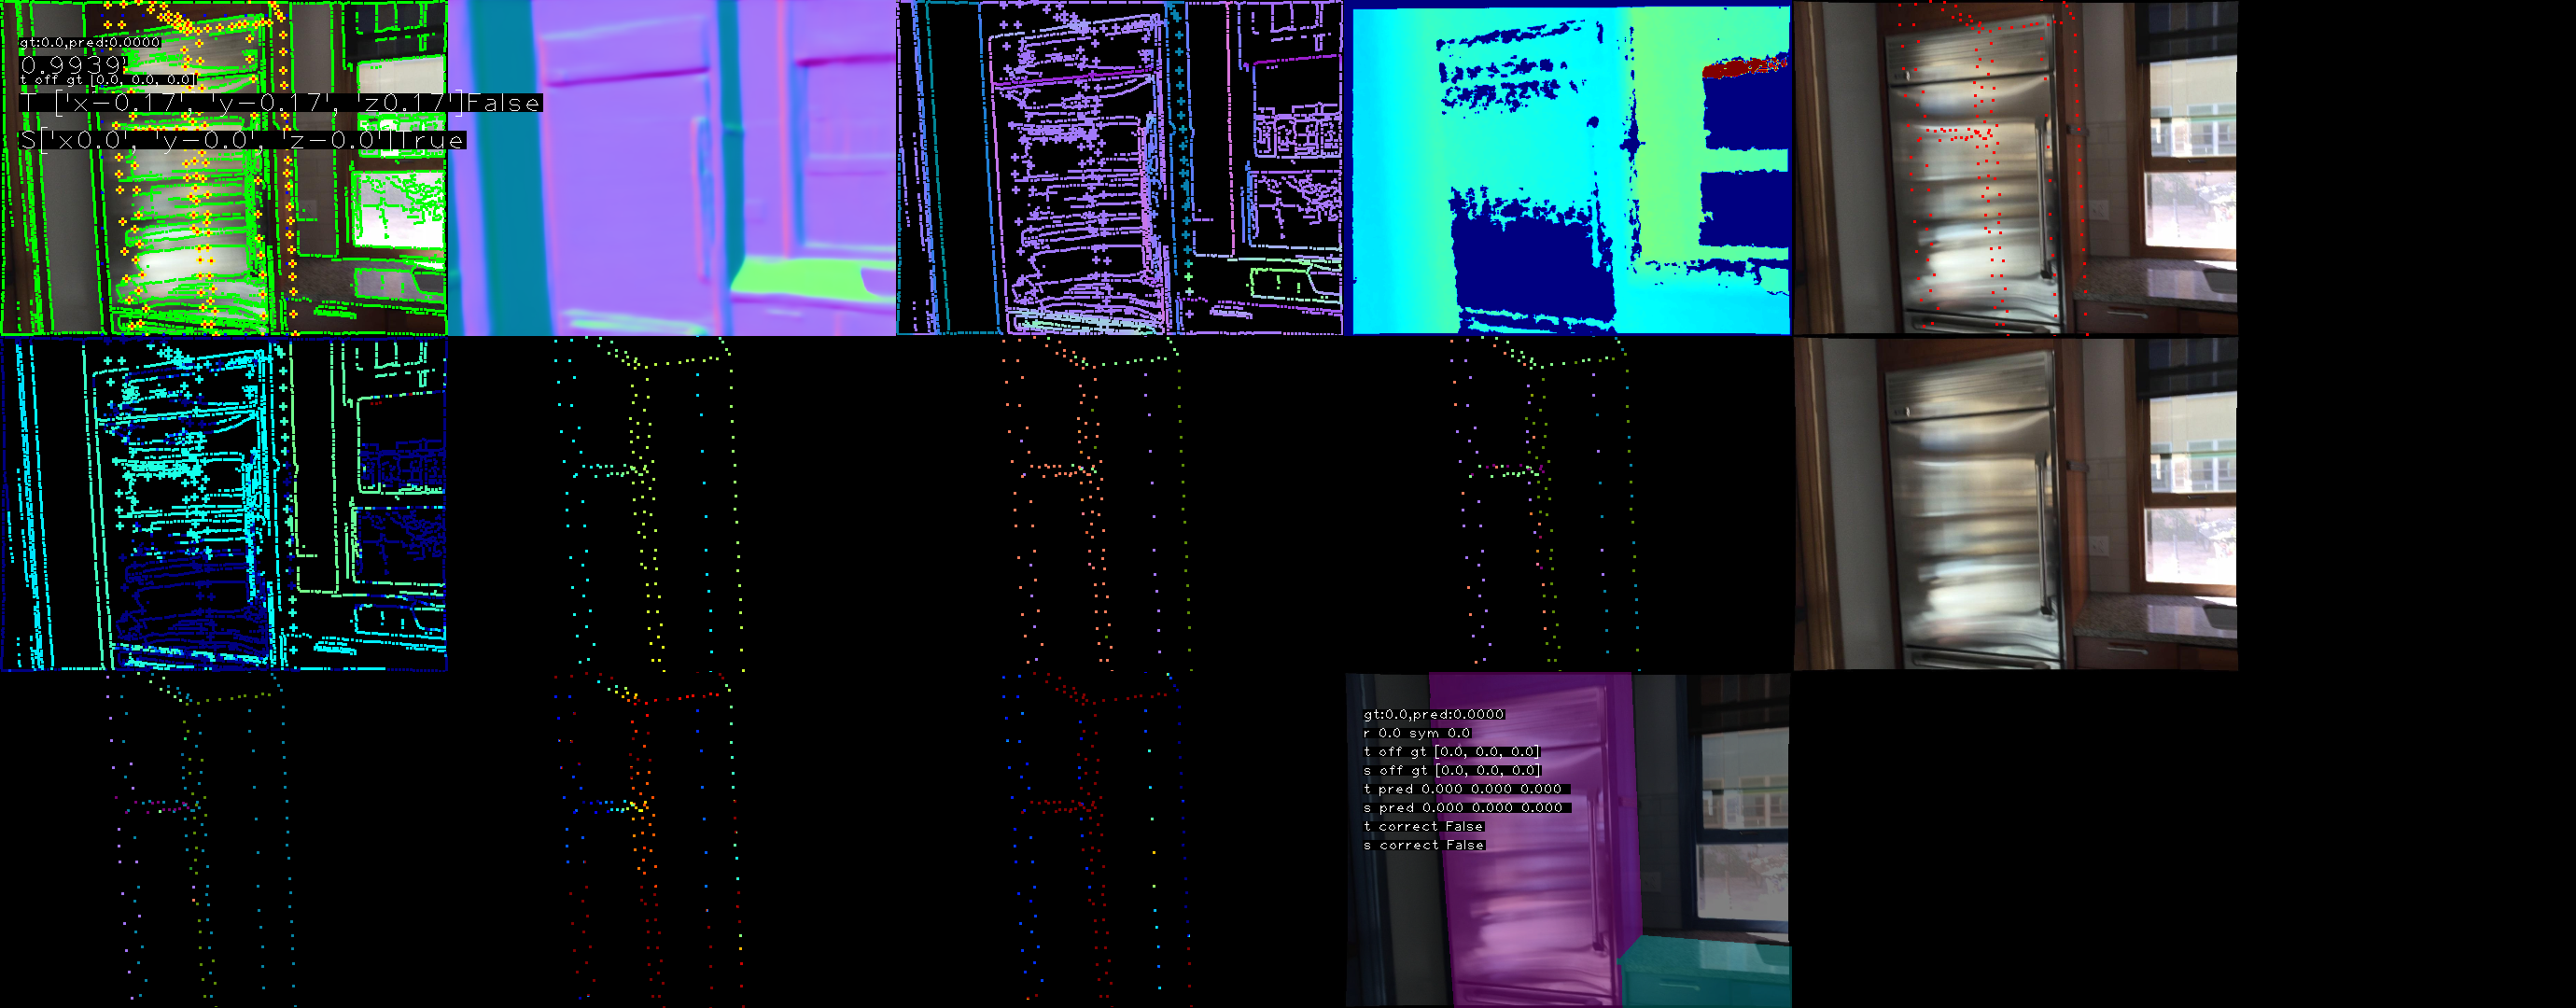

In [ ]:
ipyplot.plot_images([output[2][0] for output in outputs], max_images=20, img_width=1300)

closest_T_closest_S



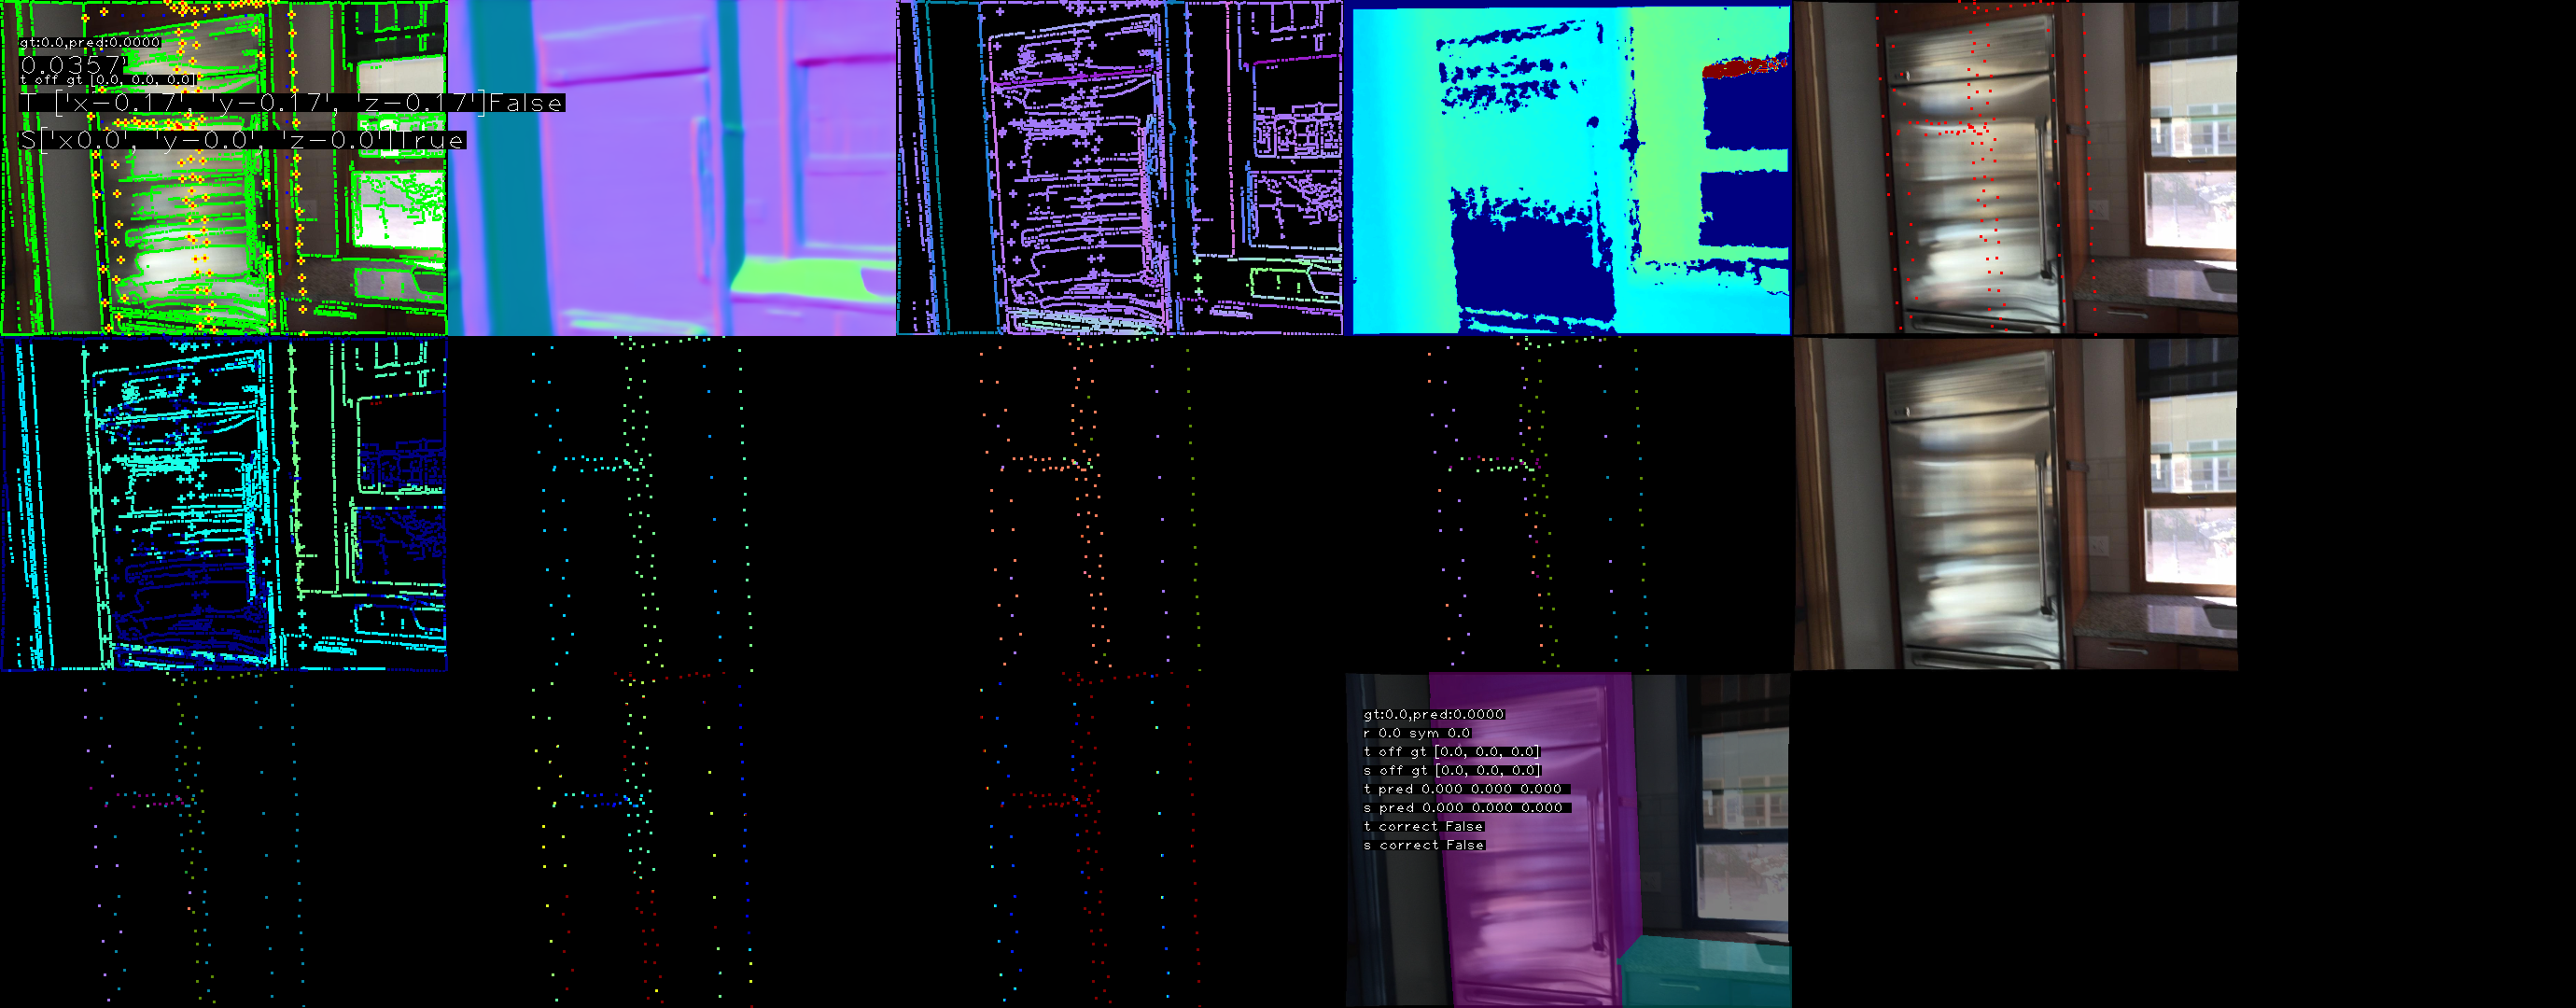


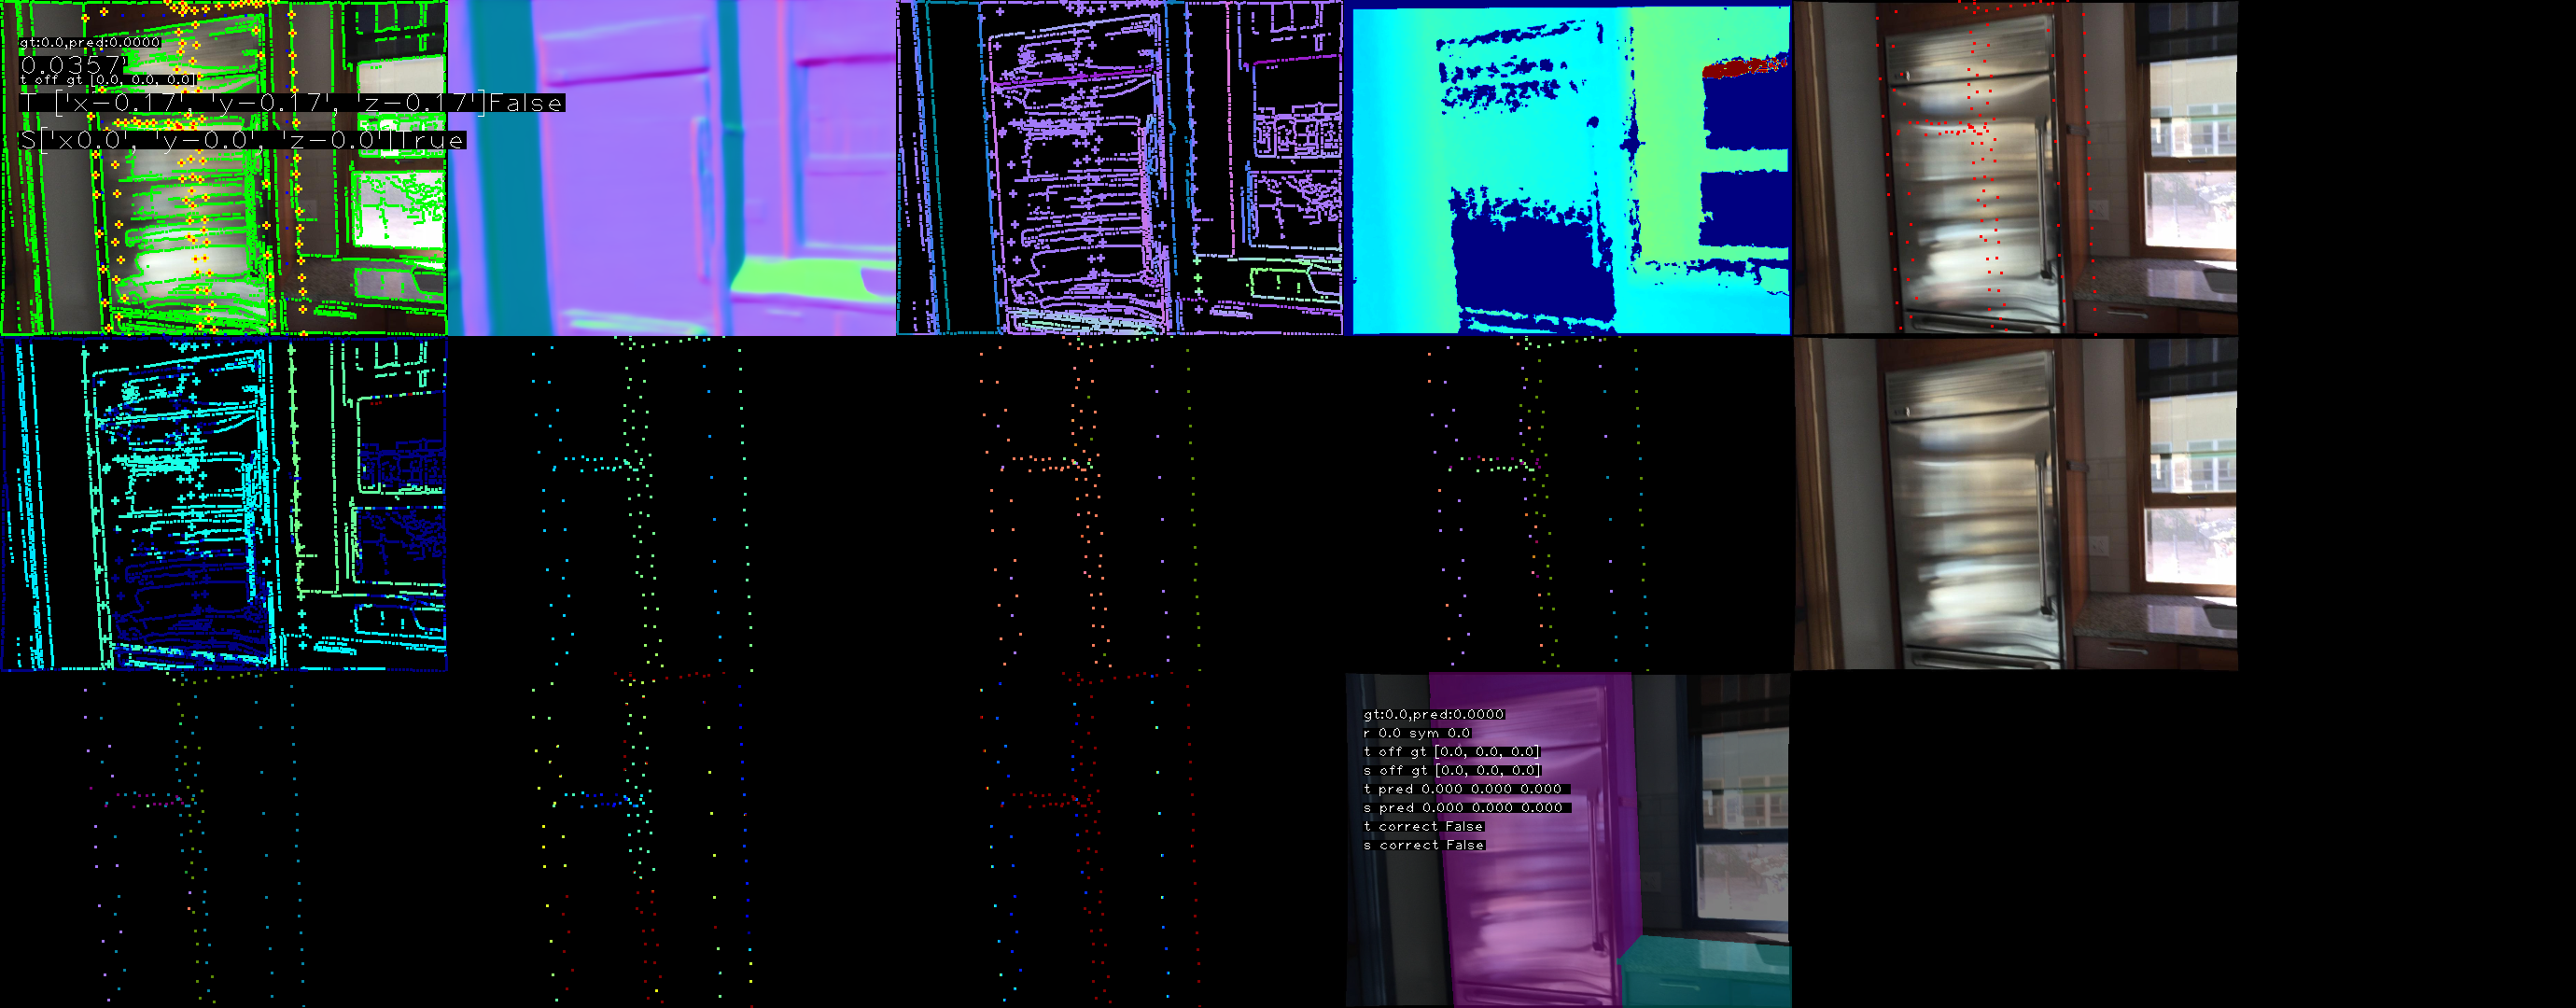

closest_T_selected_S



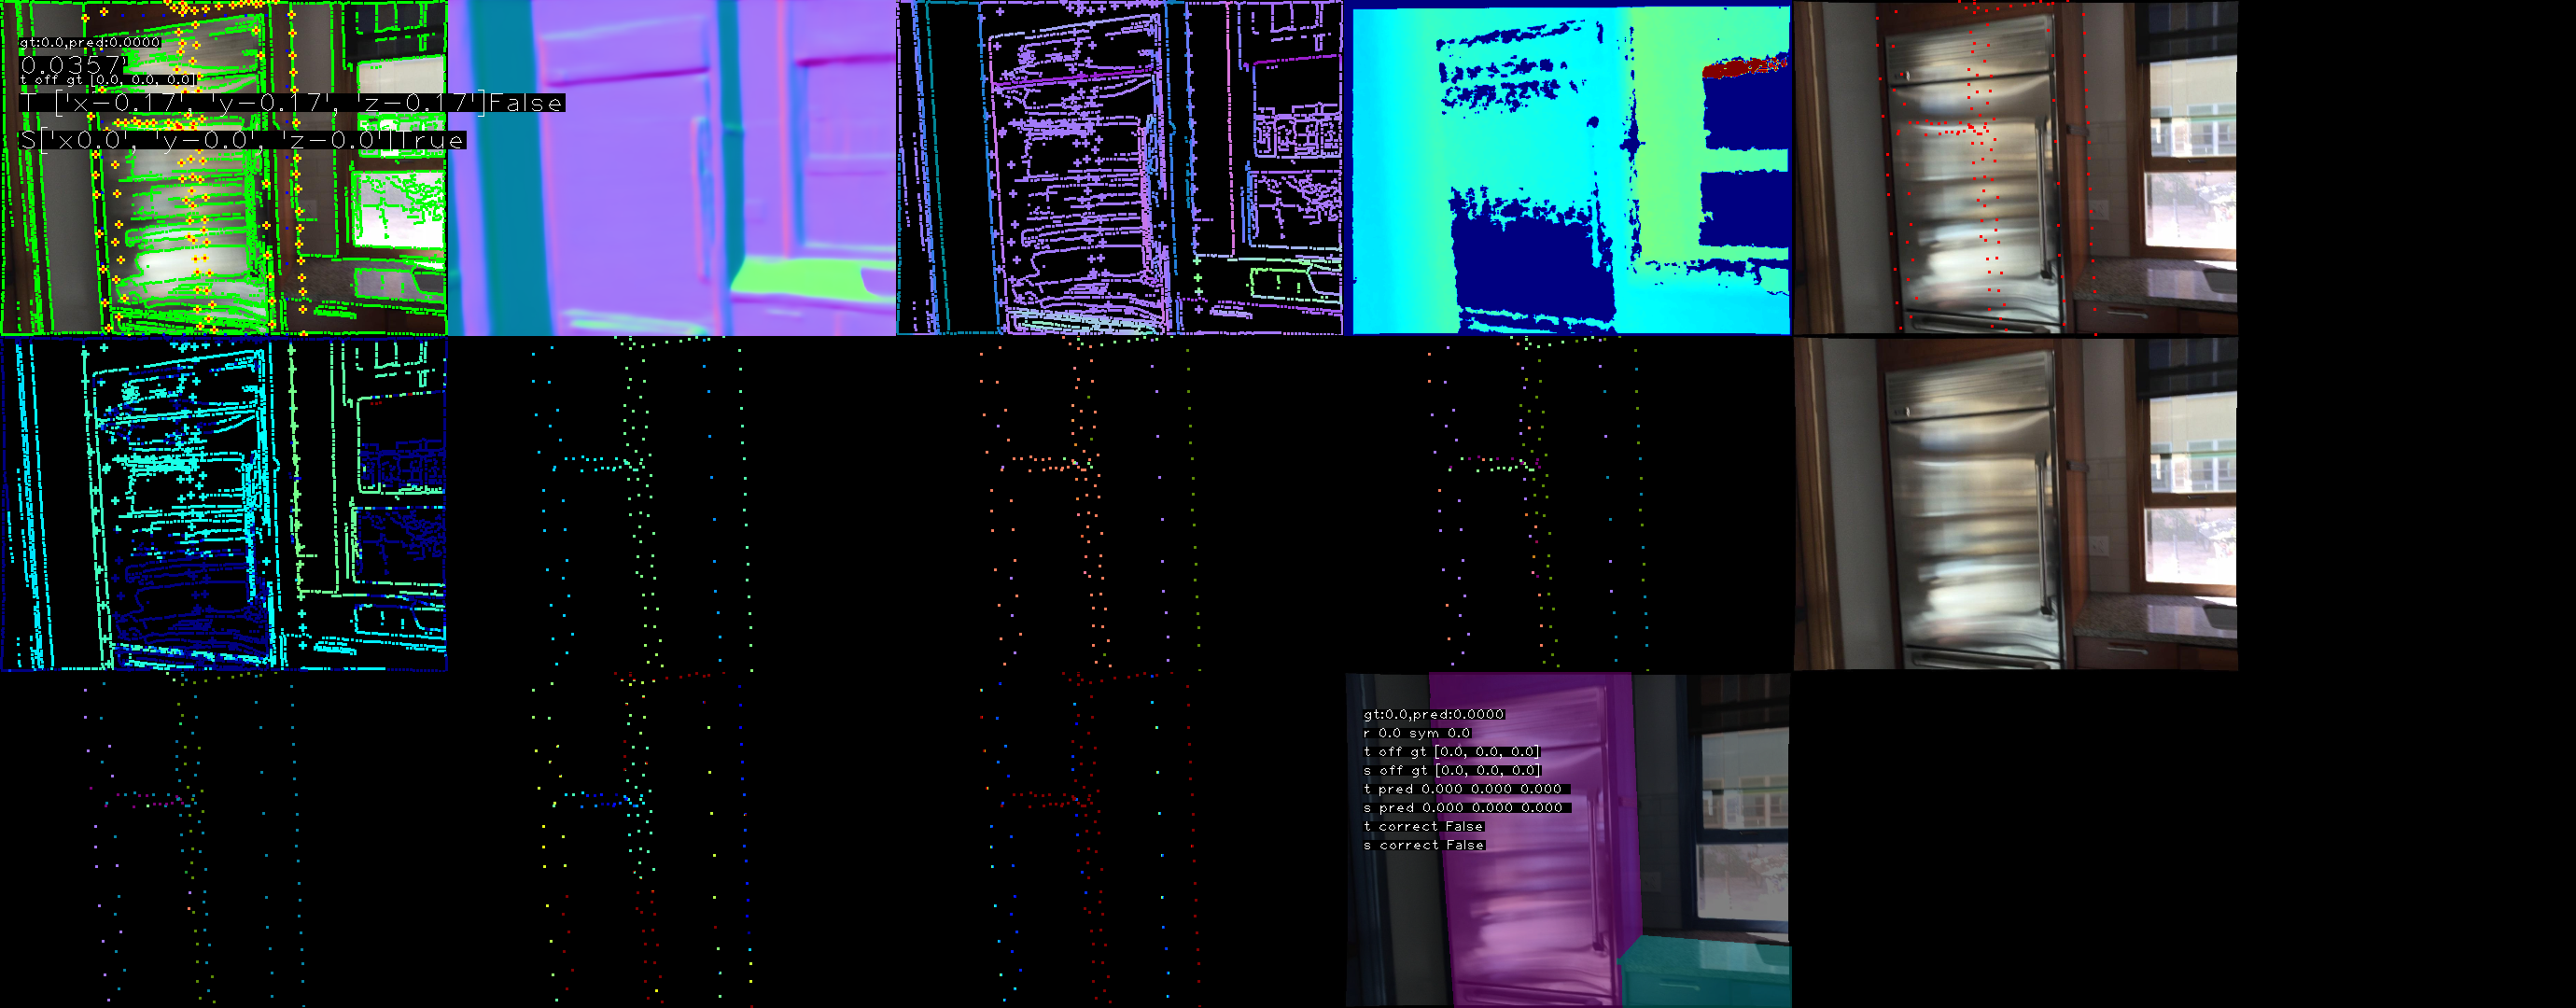


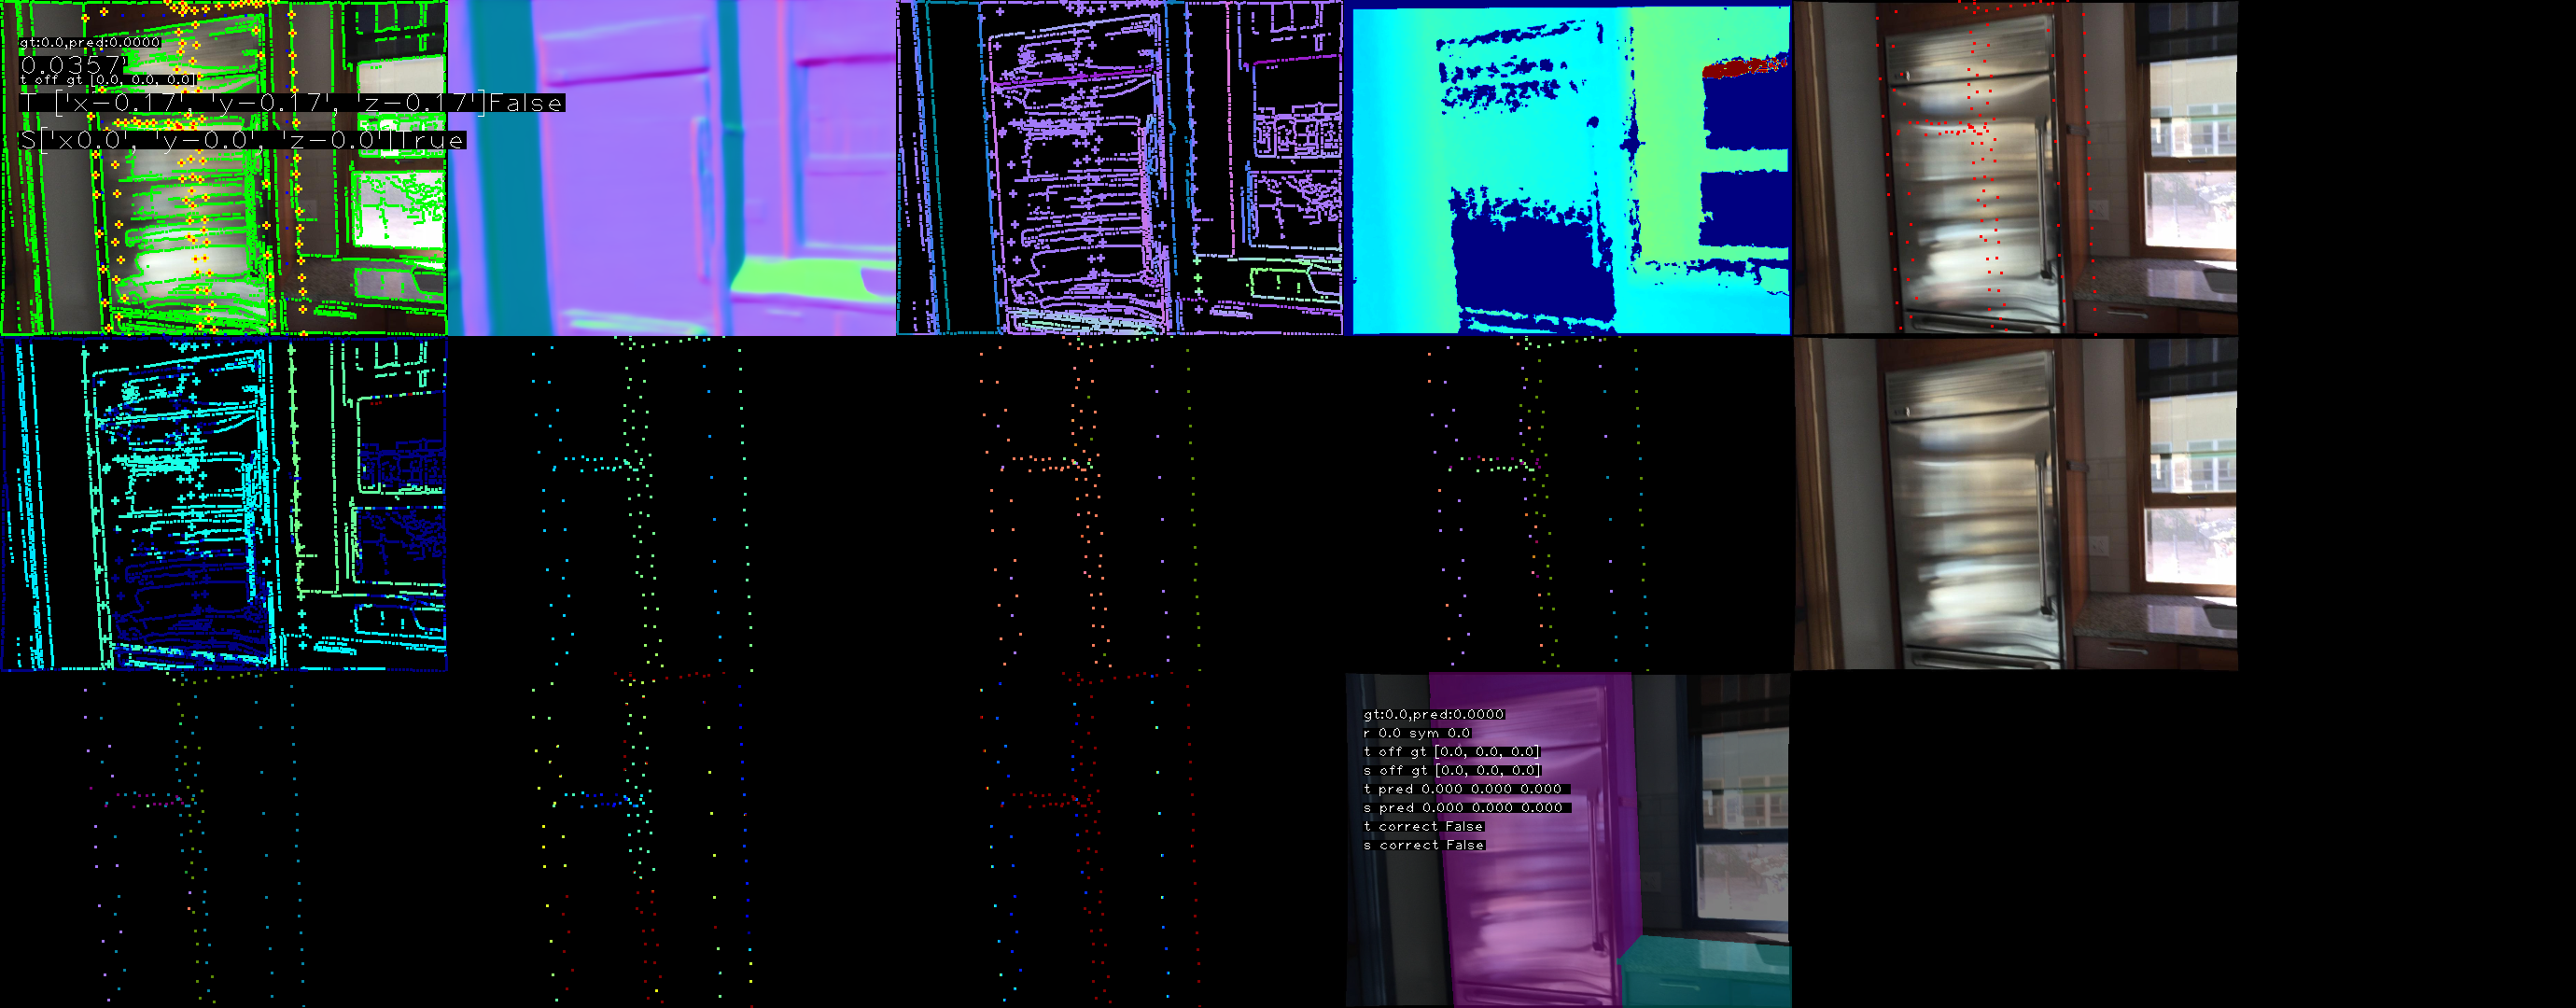

selected_T_closest_S



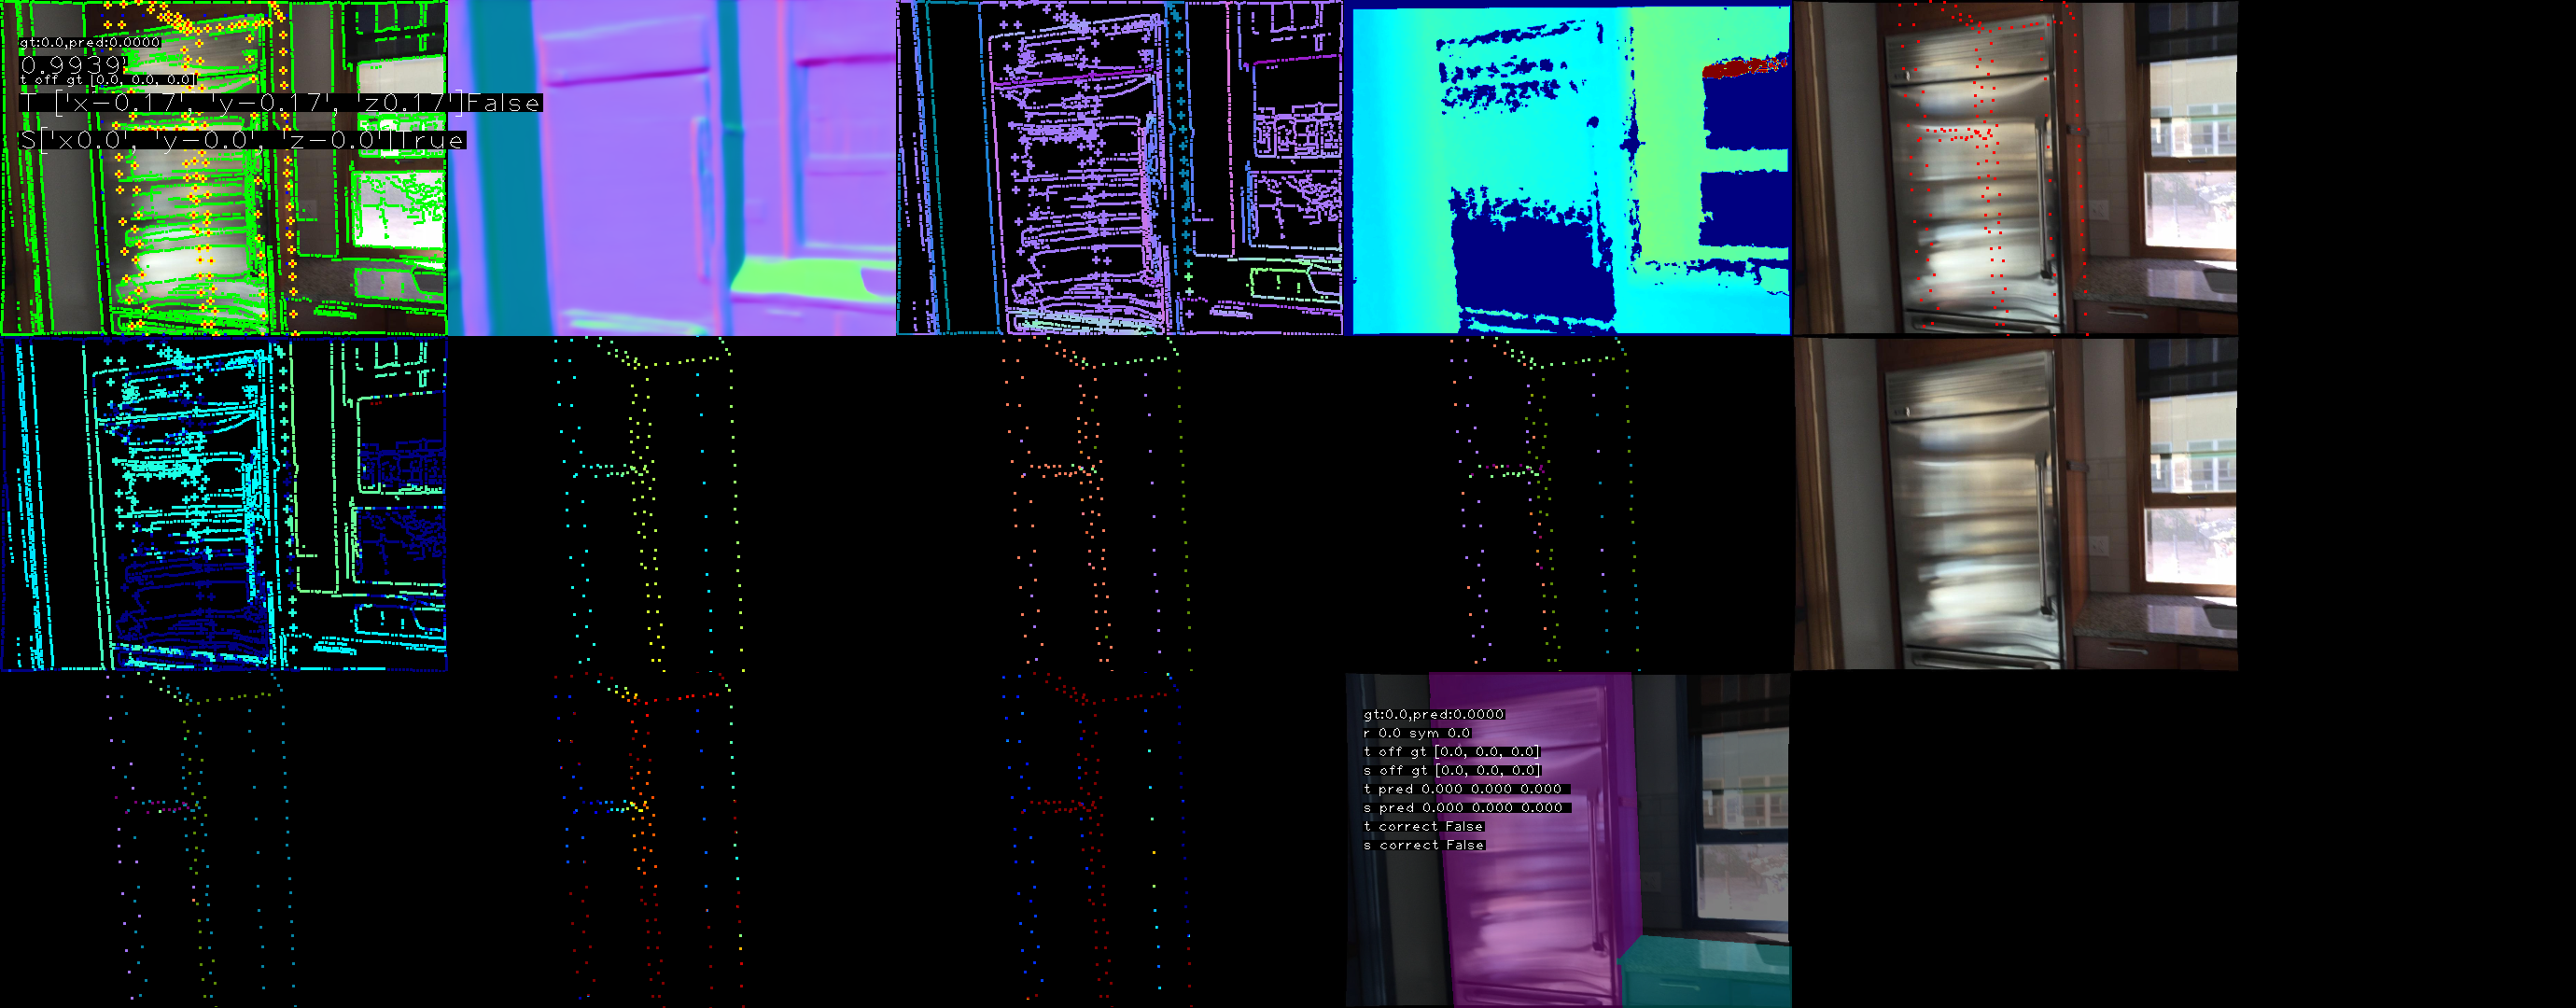


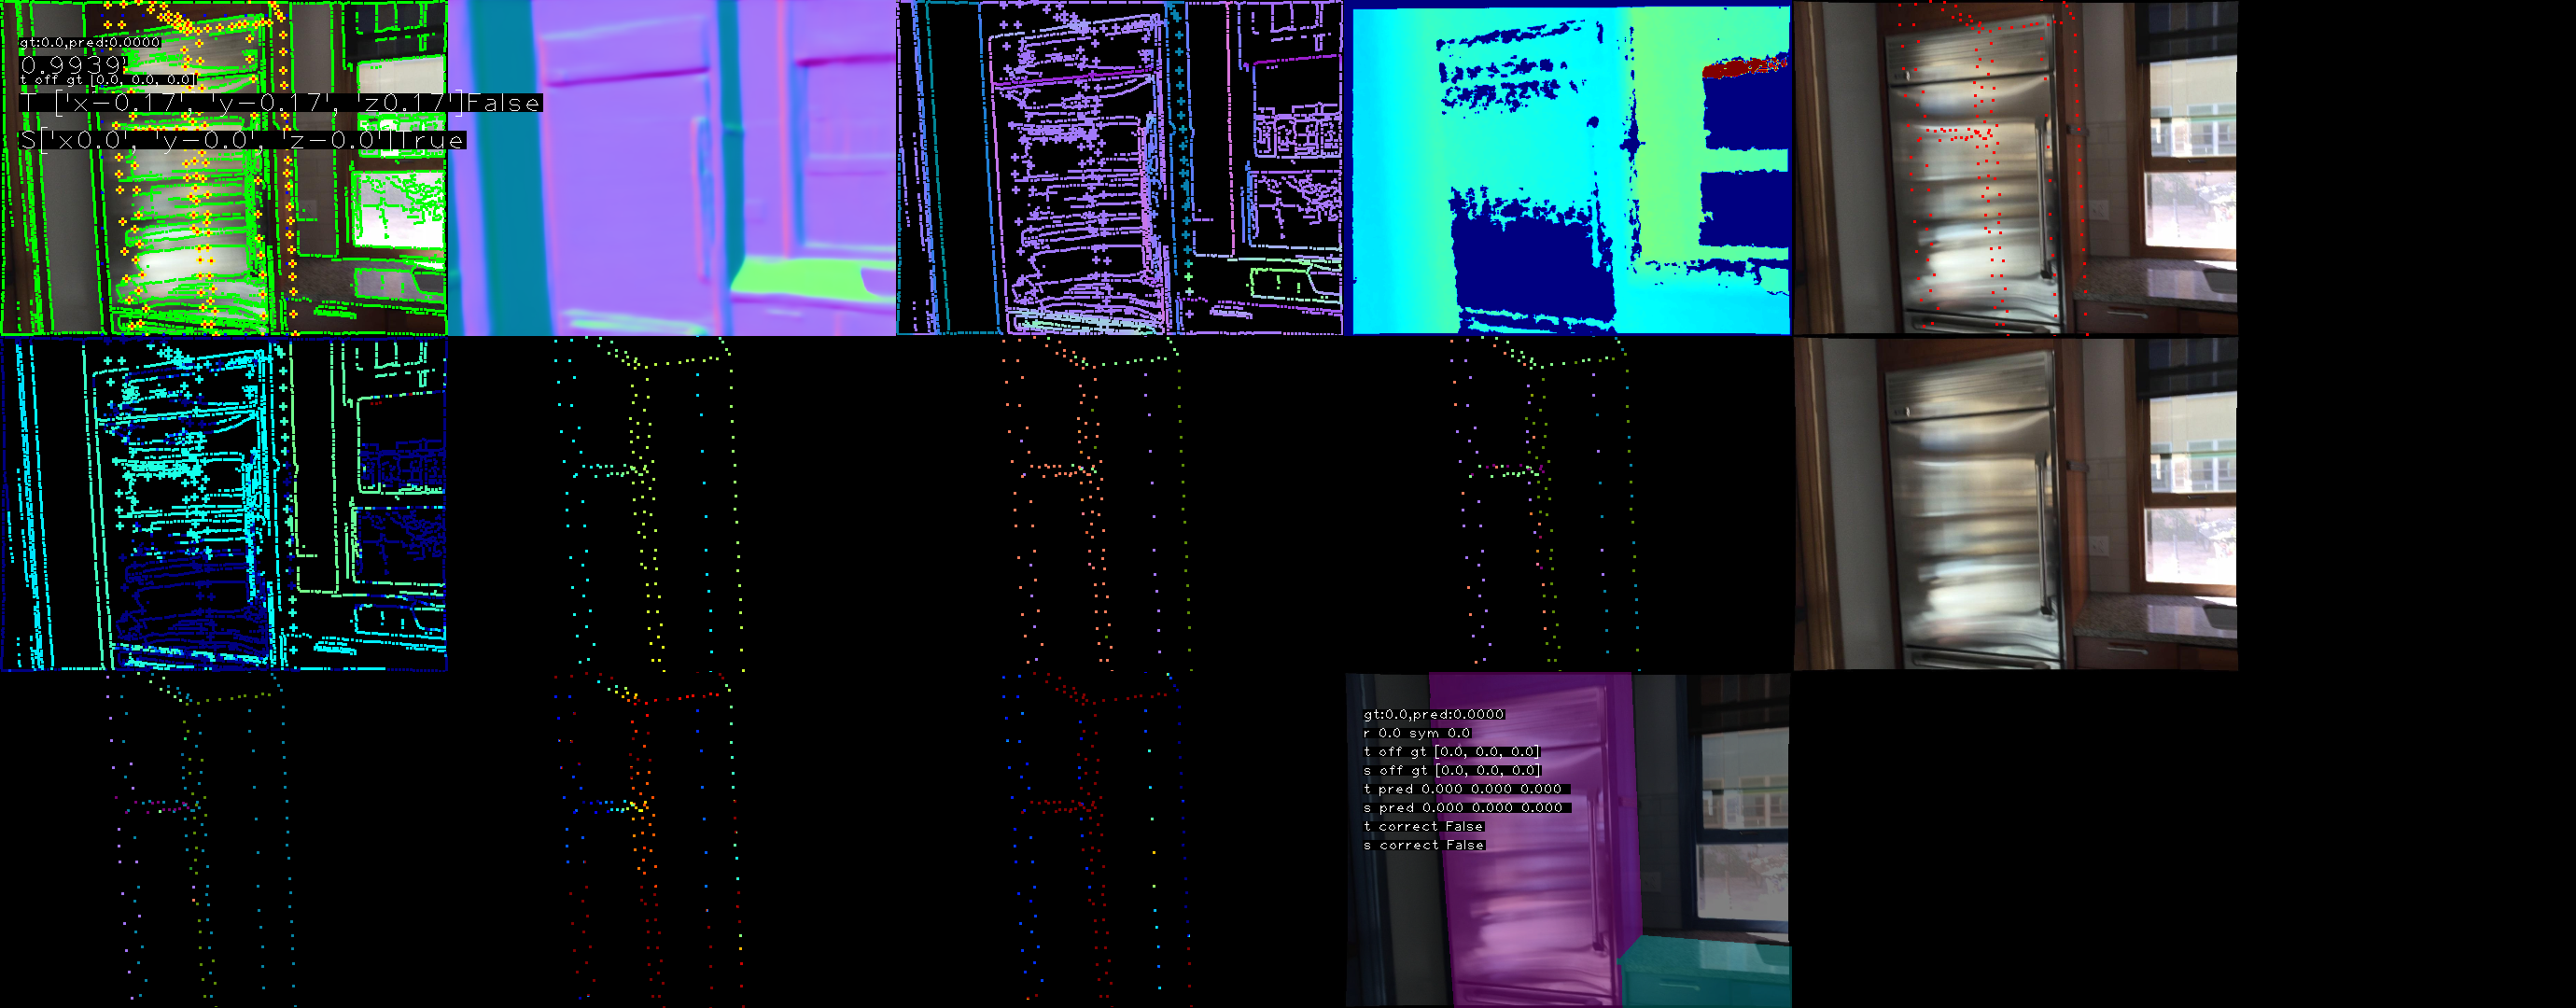

In [ ]:
# CLOSEST TO GT TS
for k in range(1,4):
    print(img_names[k])
    ipyplot.plot_images([output[2][k] for output in outputs], max_images=20, img_width=1300)

In [ ]:
threshold = 0.0

Ts = factor_output['T']
factor_selected = factor_output['factors'][:,0]

print('Ts',Ts.shape)
print('fact',factor_selected.shape)
print('pose_information',pose_information)

create_k3d_plot(Ts[factor_selected > threshold],factor_selected[factor_selected > threshold],np.array(pose_information['gt_T']),point_size=get_pointsize_from_Ts(Ts),highlight='max',relative_highlight_size=1)


Ts (64, 3)
fact (64,)
pose_information {'predicted_r': [[-0.28173255684143034, 0.05285631899361211, -0.9580359993017151], [0.09120560564995862, 0.9954355860902101, 0.02809860215854535], [0.9551483151393896, -0.07946196252097916, -0.28526740542638246]], 'predicted_t': [0.14736264944076538, -0.21984095871448517, 2.3970894813537598], 'predicted_s': [7.594149320822657, 3.3795951190507942, 4.230991755729975], 'predicted_s_normalised': [2.705939769744873, 2.8546359539031982, 1.6901373863220215], 'lines_3D_available': True, 'lines_2D_available': True, 'indices': [0], 'factor': [0.9938749670982361], 'in_limits': 'False', 'gt_R': [[0.9387268934859131, 0.055104346402928585, -0.3402277560860981], [-0.029432391015890683, 0.996347324779735, 0.0801638885317967], [0.34340263266597587, -0.065238275642976, 0.9369202363605511]], 'gt_T': [0.31402930946683316, -0.05317429755648109, 2.230422845229646], 'gt_S_normalised': [2.705939684843675, 2.8546359790519173, 1.6901374275545458], 'gt_angles': [-3.35946920

/scratch/fml35/environments/shape_env_octo/lib/python3.6/site-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "int64" does not match required type "uint32". A coerced copy has been created.
  np.dtype(self.dtype).name))
/scratch/fml35/environments/shape_env_octo/lib/python3.6/site-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  np.dtype(self.dtype).name))


Output()

In [ ]:
with open('/scratch/fml35/experiments/eval_classifier_grid/exp_003_gt_scale_gt_retrieval/T_lines_factors/scene0011_00-000200_00_000_02_00.pickle','rb') as f:
    factor_output = pickle.load(f)

In [10]:
threshold = 0.0

Ts = factor_output['T']
factor_selected = factor_output['factors'][:,0]

create_k3d_plot(Ts[factor_selected > threshold],factor_selected[factor_selected > threshold],np.zeros(3),point_size=get_pointsize_from_Ts(Ts),highlight='max',relative_highlight_size=1)

/scratch/fml35/environments/shape_env_octo/lib/python3.6/site-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "int64" does not match required type "uint32". A coerced copy has been created.
  np.dtype(self.dtype).name))
/scratch/fml35/environments/shape_env_octo/lib/python3.6/site-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  np.dtype(self.dtype).name))


Output()

: 